In [ ]:
import os
#import splitfolders
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
##
import matplotlib.pyplot as plt
from keras.regularizers import l2
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix
from skimage import transform
from skimage import color, exposure, morphology, measure
from scipy.ndimage import median_filter
from skimage import feature
from skimage.filters import frangi
from skimage.measure import shannon_entropy
from skimage.morphology import binary_erosion, binary_dilation, disk
from tensorflow.keras.optimizers import Adam

from keras.applications import InceptionV3
from keras import layers, models, optimizers

from tensorflow import keras
from keras import Sequential
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.layers import Dense
from tensorflow.keras import layers
from keras.applications import VGG19
from tensorflow.keras.applications import VGG19

In [ ]:
# Set the path to your dataset
data_dir = "/content/drive/MyDrive/Kaggle_Dataset"

In [ ]:
# Create an ImageDataGenerator for data augmentation         Data Augmentation
# It generate more images using below parameters
dataset_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
augmented_data = dataset_datagen.flow_from_directory(data_dir,    # this is the target directory
                                      target_size=(224, 224),    # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')

Found 1482 images belonging to 4 classes.


In [ ]:
augmented_data.class_indices

{'bacterial_blight': 0, 'curl_virus': 1, 'fusarium_wilt': 2, 'healthy': 3}

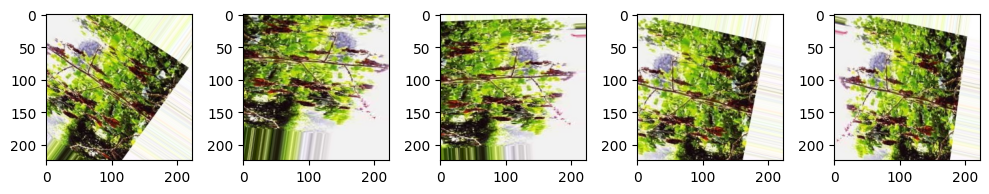

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

images = [augmented_data[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
classes = ["healthy", "bacterial_blight", "curl_virus", "fusarium_wilt"]
img_size = (224, 224)

def load_and_preprocess_data(data_dir, classes):
    data = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class {class_name}. Skipping.")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            if not os.path.exists(img_path):
                print(f"Warning: Image not found at {img_path}. Skipping.")
                continue

            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Failed to read image at {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(classes.index(class_name))

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

data, labels = load_and_preprocess_data(data_dir, classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Create an VGG19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a custom model on top of vgg19
from tensorflow.keras.layers import Flatten

vgg19_model = models.Sequential()
vgg19_model.add(base_model)
vgg19_model.add(layers.GlobalAveragePooling2D())
vgg19_model.add( Flatten() )
vgg19_model.add(layers.Dense(512, activation='relu'))
vgg19_model.add( BatchNormalization())
vgg19_model.add(layers.Dropout(0.1))
vgg19_model.add(layers.Dense(256, activation='relu'))
vgg19_model.add(layers.Dropout(0.25))
vgg19_model.add(layers.Dense(4, activation='softmax'))

In [ ]:
# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model summary
vgg19_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
model_path11 = '/content/drive/MyDrive/training_models/vgg19_kaggle_predictor.h5'
checkpoint = ModelCheckpoint(model_path11, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Train the Inception V3 model
history = vgg19_model.fit(X_train, y_train,
                          epochs=150,
                          verbose=1,
                          validation_split=0.2,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/150
30/30 [==============================] - ETA: 0s - loss: 1.2210 - accuracy: 0.4789
Epoch 1: val_accuracy improved from -inf to 0.38819, saving model to /content/drive/MyDrive/training_models/vgg19_kaggle_predictor.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 27s 488ms/step - loss: 1.2210 - accuracy: 0.4789 - val_loss: 1.3008 - val_accuracy: 0.3882
Epoch 2/150
30/30 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.7563
Epoch 2: val_accuracy improved from 0.38819 to 0.49367, saving model to /content/drive/MyDrive/training_models/vgg19_kaggle_predictor.h5
30/30 [==============================] - 6s 194ms/step - loss: 0.7023 - accuracy: 0.7563 - val_loss: 1.2328 - val_accuracy: 0.4937
Epoch 3/150
30/30 [==============================] - ETA: 0s - loss: 0.5109 - accuracy: 0.8397
Epoch 3: val_accuracy improved from 0.49367 to 0.60759, saving model to /content/drive/MyDrive/training_models/vgg19_kaggle_predictor.h5
30/30 [==============================] - 6s 209ms/step - loss: 0.5109 - accuracy: 0.8397 - val_loss: 1.1652 - val_accuracy: 0.6076
Epoch 4/150
30/30 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8745
Epoch 4: val_accuracy improved from 0.60759 to 

In [ ]:
# Evaluate the Xception model
print("[INFO] Calculating model accuracy")
scores = vgg19_model.evaluate(X_train, y_train)
print(f"Training Accuracy: {round(scores[1], 4) * 100}%")

print("[INFO] Calculating model accuracy")
scores = vgg19_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(scores[1], 4) * 100}%")

[INFO] Calculating model accuracy
38/38 [==============================] - 7s 191ms/step - loss: 0.0103 - accuracy: 0.9958
Training Accuracy: 99.58%
[INFO] Calculating model accuracy
10/10 [==============================] - 4s 468ms/step - loss: 0.1384 - accuracy: 0.9529
Test Accuracy: 95.28999999999999%


In [ ]:
vgg19_predictions_test = vgg19_model.predict(X_test)
vgg19_predictions_test = np.argmax(vgg19_predictions_test, axis=1)

10/10 [==============================] - 2s 168ms/step


In [ ]:
vgg19_eval = vgg19_model.evaluate(X_test, y_test)
vgg19_accuracy = vgg19_eval

10/10 [==============================] - 2s 157ms/step - loss: 0.1384 - accuracy: 0.9529


In [ ]:
vgg19_eval

[0.13840150833129883, 0.9528619647026062]

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class_labels = ["bacterial blight", "fusarium wilt", "curl virus", "healthy"]
def evaluate_model(vgg19_predictions_test, y_test, model_name):
    accuracy = accuracy_score(y_test, vgg19_predictions_test)
    precision = precision_score(y_test, vgg19_predictions_test, average='weighted')
    recall = recall_score(y_test, vgg19_predictions_test, average='weighted')
    f1 = f1_score(y_test, vgg19_predictions_test, average='weighted')
    conf_matrix = confusion_matrix(y_test, vgg19_predictions_test)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True/Actual')
    plt.show()

    class_report = classification_report(y_test, vgg19_predictions_test, target_names=class_labels)
    print('Classification Report:')
    print(class_report)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

      # Return the metrics
    return accuracy, precision, recall, f1

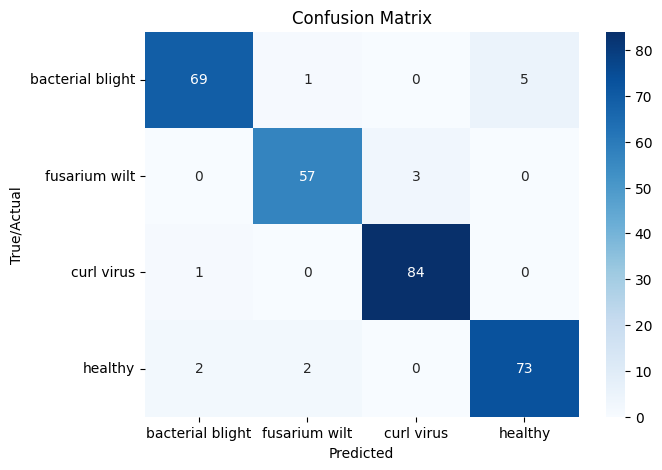

Classification Report:
                  precision    recall  f1-score   support

bacterial blight       0.96      0.92      0.94        75
   fusarium wilt       0.95      0.95      0.95        60
      curl virus       0.97      0.99      0.98        85
         healthy       0.94      0.95      0.94        77

        accuracy                           0.95       297
       macro avg       0.95      0.95      0.95       297
    weighted avg       0.95      0.95      0.95       297

Results for VGG19:
Accuracy: 0.9528619528619529
Precision: 0.9528891181190031
Recall: 0.9528619528619529
F1 Score: 0.9527287923815627


In [ ]:
accuracy, precision, recall, f1 = evaluate_model(vgg19_predictions_test, y_test, "VGG19")

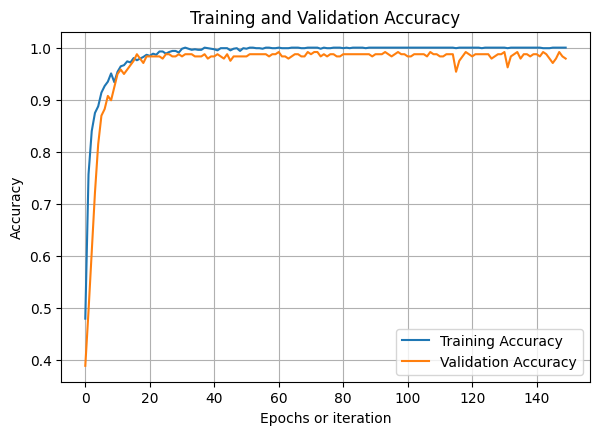

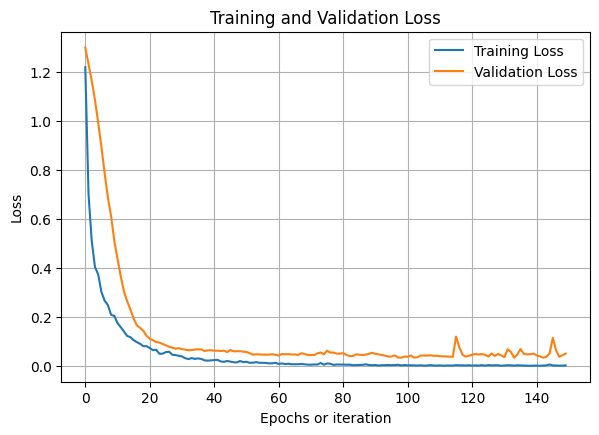

In [ ]:
#plt.figure(figsize=(10, 5))
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
# (2,2) means Width and Height of Diagram
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs or iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs or iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()